# Tutorial 4 Homework
## Active Galactic Nuclei
### MASS S2

Shoaib Shamsi

We will first, import all the packages that the Fantasy tutorial needs.

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import numpy as np
import pandas as pd

import glob

Next, let's import all the Fantasy modules we're going to use.

In [14]:
from fantasy_agn.tools import read_sdss, read_text, read_gama_fits

from fantasy_agn.models import create_input_folder
from fantasy_agn.models import create_feii_model, create_model, create_tied_model, continuum, create_line, create_fixed_model

We now choose a boss QSO (Best object ID: 1237680310155674085, Spec object ID: 7316344545167560704) with Plate ID 6498, MJD 56565, and Fibre ID 898. This broadline QSO is located at (RA: 00:01:56.30, DEC: +31:44:42.10) at a redshift of $z \approx 0.389$. Find out more about this QSO on the [SDSS SAS](https://dr16.sdss.org/optical/spectrum/view?plateid=6498&mjd=56565&fiberid=898).

We arrive at this choice after making sure that our QSO has as low a redshift as possible. This is because we found that QSOs at higher redshifts observed with the boss spectrograph result in a rest spectrum in the UV range. We'd like to model our spectrum with lines in the optical. Let's real the `.FITS` file.

In [15]:
s = read_sdss('spec-6498-56565-0898.fits')

In [16]:
# Dust and redshift correction
s.DeRedden()
s.CorRed()

In [17]:
# let's fit the spectrum with the host galaxy continuum
s.fit_host_sdss(mask_host=True, custom=False)

Host contribution is negliglable


We will now plot the observed spectrum. 

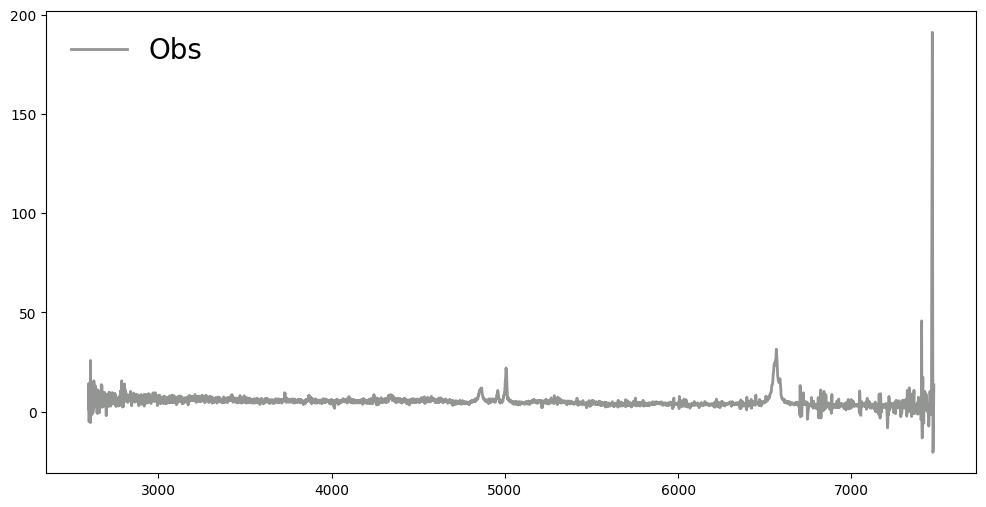

In [18]:
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.legend(prop={'size': 20}, frameon=False, ncol=2)

Looks good. Let's create the input lines folder.

In [19]:
xmin = s.wave.min()
xmax = s.wave.max()

create_input_folder(xmin=xmin,xmax=xmax, path_to_folder='liness/')

Directory  liness/  Created 


We sill now create models for lines in the desired wavelength range.

In [20]:
cont=continuum(s,min_refer=5690, refer=5700, max_refer=5710)
broad=create_fixed_model(['hydrogen.csv'], name='br')
he=create_fixed_model(['helium.csv'], name='he',fwhm=3000, min_fwhm=1000, max_fwhm=5000)
narrow=create_tied_model(name='OIII5007',files=['narrow_basic.csv','hydrogen.csv'],prefix='nr', fwhm=1000,min_offset=0, max_offset=300, min_fwhm=900, max_fwhm=1200,fix_oiii_ratio=True, position=5006.803341, included=True,min_amplitude=0.2)
fe=create_feii_model(name='feii', fwhm=1800, min_fwhm=1000, max_fwhm=2000, offset=0, min_offset=-3000, max_offset=3000)
#fe.amp_b4p.min=10 #An example how to force the amplitude of a selected FeII multiplet.

In [21]:
# The summ model described here.
model = cont+broad+narrow+fe+he

In [22]:
# Perform fitting with the model
s.fit(model, ntrial=2)

stati 96407.64064210706
1 iter stat:  234.2380825065411
2 iter stat:  78.47963804461688


Finally, let's plot the fitted model results.

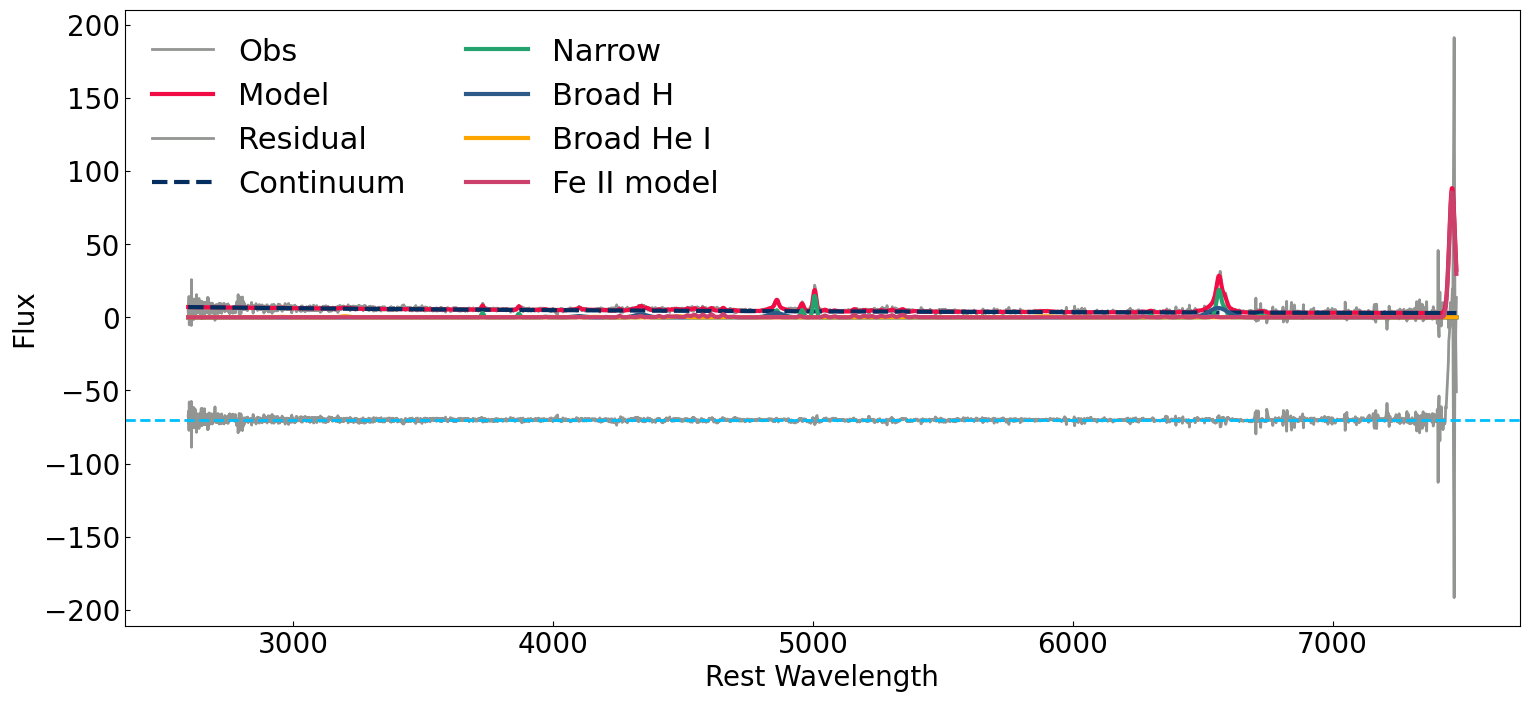

In [23]:
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(18,8))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.plot(s.wave, model(s.wave), color="#F10C45",label='Model',lw=3)
plt.plot(s.wave, model(s.wave)-s.flux-70, '-',color="#929591", label='Residual', lw=2)
plt.axhline(y=-70, color='deepskyblue', linestyle='--', lw=2)

plt.plot(s.wave, cont(s.wave),'--',color="#042E60",label='Continuum', lw=3)
plt.plot(s.wave, narrow(s.wave),label='Narrow',color="#25A36F",lw=3)
plt.plot(s.wave, broad(s.wave), label='Broad H', lw=3, color="#2E5A88")
plt.plot(s.wave, he(s.wave), label='Broad He I', lw=3, color="orange")
plt.plot(s.wave, fe(s.wave),'-',color="#CB416B",label='Fe II model', lw=3)

plt.xlabel('Rest Wavelength',fontsize=20)
plt.ylabel('Flux',fontsize=20)
#plt.xlim(4000,7000)
#plt.ylim(-150,900)
plt.tick_params(which='both', direction="in")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(prop={'size': 22}, frameon=False, ncol=2)

plt.savefig('fantasy_fit.pdf')